In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from common import *
from envs import MIMICEnv
from rl_policies import D3QNAgent, CQLAgent, IQLAgent
from ope import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data

sepsis_df = pd.read_csv('data/sepsis_df.csv')
env = MIMICEnv(sepsis_df)


cutoff = int(0.8 * len(sepsis_df['icustayid']))

train_ids = sepsis_df['icustayid'][:cutoff]
train_df = sepsis_df[sepsis_df['icustayid'].isin(train_ids)]

test_ids = sepsis_df['icustayid'][cutoff:]
test_df = sepsis_df[sepsis_df['icustayid'].isin(test_ids)]

In [21]:
# tools for training, evaluating, visualizing our policies


def train_policy(model, env, n_episodes=10_000, update_freq=50, verbose=True, model_name=''):
    """
    Training loop to learn a Q-function.
    """
    assert model_name in ('D3QN', 'CQL', 'IQL')
    
    rewards, lengths, all_q_vals = [], [], []

    for i in tqdm(range(n_episodes)):
        state = env.reset()
        done = False
        episode_q_vals = []
        total_reward, episode_length = 0, 0

        while not done:
            action = model.select_action(state)
            next_state, reward, done, _ = env.step(action)
            model.learn(state, action, reward, next_state, done)
            
            # update for next timestep
            state = next_state
            total_reward += reward
            episode_length += 1

            if i % update_freq == 0:
                q_vals = model.get_q_values(state)

                # take the max_a Q(s,a)
                episode_q_vals.append(q_vals.max().item())

                # occasionally, plot the q-function as a heatmap
                #if np.random.rand() < 0.01:
                    #fig, ax = plt.subplots()
                    #q_array = np.array(q_vals).reshape((5,5))
                    #plot_heatmap(q_array, f'{model_name} Q(s,a)', ax)
                    #plt.show()

        if i % update_freq == 0:
            rewards.append(total_reward)
            lengths.append(episode_length)

            # average Q(s',a) over all states in episode
            avg_q_val = np.mean(episode_q_vals)
            all_q_vals.append(avg_q_val)

            # update the target network weights to match main network
            if model_name in ('D3QN', 'CQL'):
                model.hard_update()


    if verbose:
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))

        axs[0].plot(pd.Series(rewards))
        axs[0].set_title(f'{model_name} reward per episode')
        
        axs[1].plot(pd.Series(lengths))
        axs[1].set_title(f'{model_name} episode lengths')

        axs[2].plot(pd.Series(all_q_vals))
        axs[2].set_title(f'{model_name} E_s max_a Q(s,a) during training')
    

def eval_policy(model, env, n_episodes=1000, model_name=''):
    """
    Evaluate our learned policy, to see what Q-function we're learning.
    """
    q_vals = []
    action_log = np.zeros((5,5))
    
    for i in tqdm(range(n_episodes)):
        state = env.reset()
        done = False
        episode_q_vals = []
        while not done:
            action = model.select_action(state, eval=True)
            next_state, reward, done, _ = env.step(action)
            
            # log action
            action_tuple = get_action_tuple(action)
            action_log[action_tuple] += 1

            if i % 10 == 0:
                # log the max q value at each timestep
                q_values = model.get_q_values(state)
                episode_q_vals.append(q_values.max().item())

        if i % 10 == 0:
            # get the average q value over the episode
            avg_q_val = np.mean(episode_q_vals)
            q_vals.append(avg_q_val)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # visualize q function
    axs[0].plot(pd.Series(q_vals))
    axs[0].set_title('E_s max_a Q(s,a) during eval')

    # visualize action selection
    plot_heatmap(action_log, f'{model_name} policy', axs[1])

    plt.show()

            

def plot_heatmap(array, plot_title, ax):
    """
    Visualize the frequency of actions selected by a policy, over the 2D action space.
    OR
    Visualize Q(s,a) over the 2D action space for a given state.
    """  
    sns.heatmap(array, cmap='crest', annot=True, ax=ax)

    ax.set_title(plot_title)
    ax.set_xlabel('vasopressor bin')
    ax.set_ylabel('iv bin')
    ax.invert_yaxis()
    ax.grid(which='minor', color='b', linestyle='-', linewidth=1)


100%|█████████████████████████████████████| 10000/10000 [02:17<00:00, 72.94it/s]


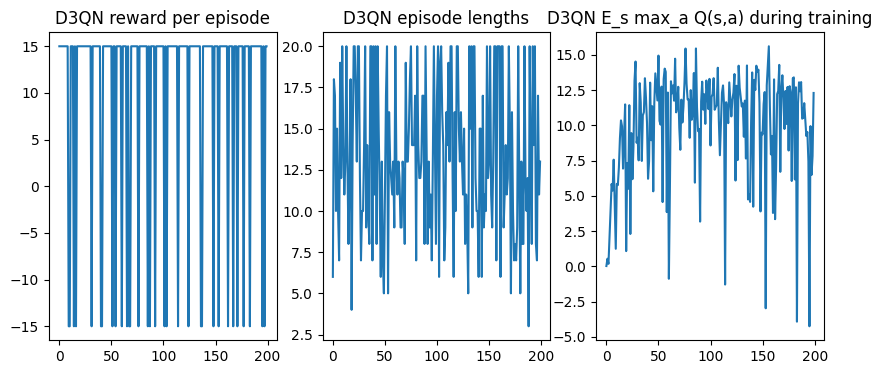

In [22]:
### Dueling Double Deep Q Networks ###

d3qn_agent = D3QNAgent(env.obs_dim, env.action_dim)

# train policy
train_policy(d3qn_agent, env, model_name='D3QN')

# save policy
torch.save(d3qn_agent.main_network.state_dict(), 'models/d3qn_policy.pth')

# load policy
#d3qn_agent.main_network.load_state_dict(torch.load('models/d3qn_policy.pth'))

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 711.36it/s]


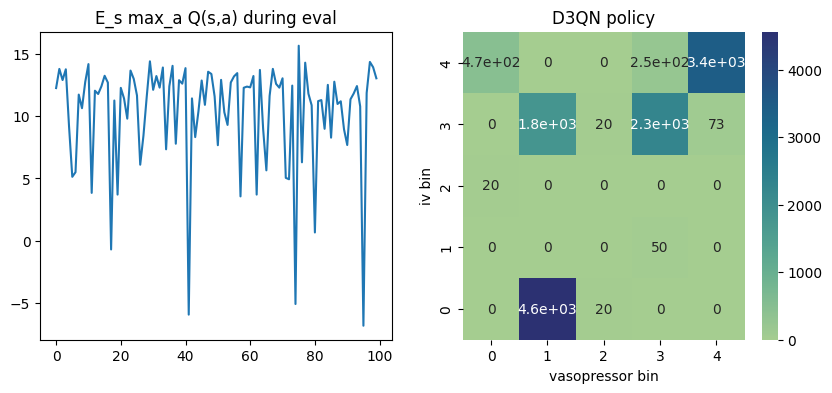

In [23]:
eval_policy(d3qn_agent, env, model_name='D3QN')

# TODO goofy ah action selection. wonder why that's happening.

In [5]:
### Conservative Q-Learning (CQL) ###

cql_agent = CQLAgent(env.obs_dim, env.action_dim)

# train policy
#train_policy(cql_agent, env, model_name='CQL')

# save policy
#torch.save(cql_agent.main_network.state_dict(), 'models/cql_policy.pth')

# load policy
cql_agent.main_network.load_state_dict(torch.load('models/cql_policy.pth'))

<All keys matched successfully>

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 750.46it/s]


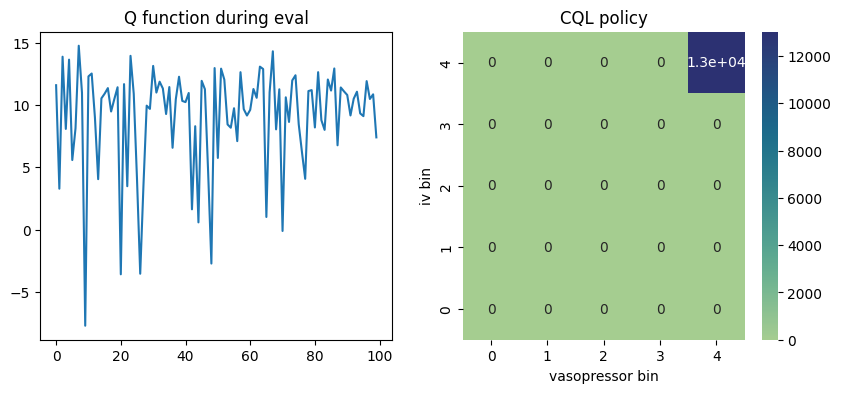

In [10]:
eval_policy(cql_agent, env, model_name='CQL')

100%|█████████████████████████████████████| 10000/10000 [04:05<00:00, 40.81it/s]


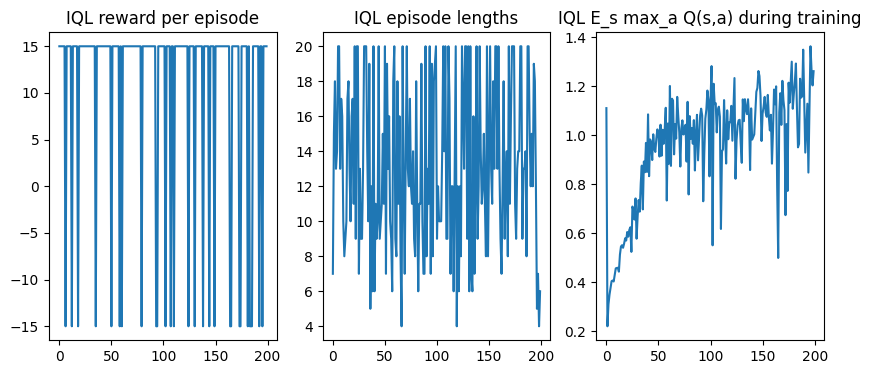

In [7]:
### Implicit Q-Learning (IQL) ###

iql_agent = IQLAgent(env.obs_dim, env.action_dim)

# train policy
train_policy(iql_agent, env, model_name='IQL')

# save policy
torch.save(iql_agent.actor.state_dict(), 'models/iql_policy.pth')

# load policy
#iql_agent.actor.load_state_dict(torch.load('models/iql_policy.pth'))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 309.81it/s]


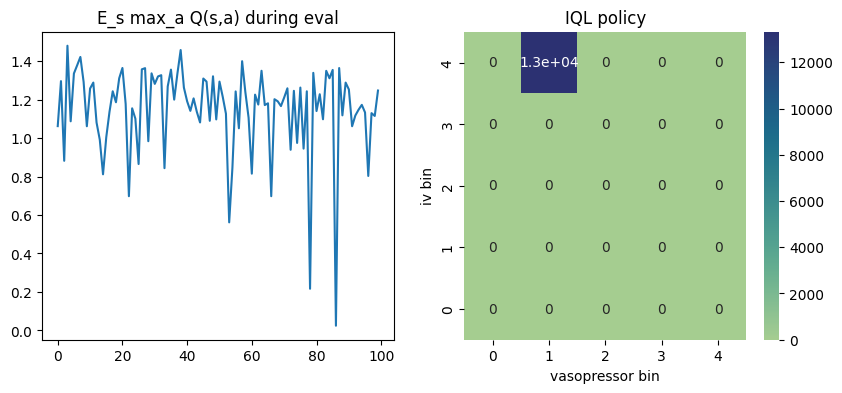

In [8]:
#torch.save(iql_agent.actor.state_dict(), 'models/iql_policy.pth')
eval_policy(iql_agent, env, model_name='IQL')

100%|██████████████████████████████████| 52921/52921 [00:04<00:00, 12185.66it/s]


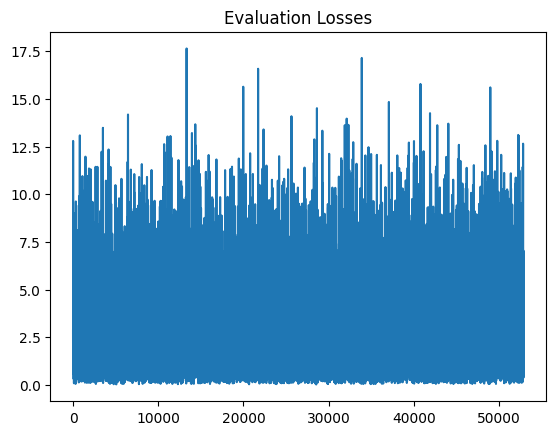

mean eval loss: 2.2297997247624872


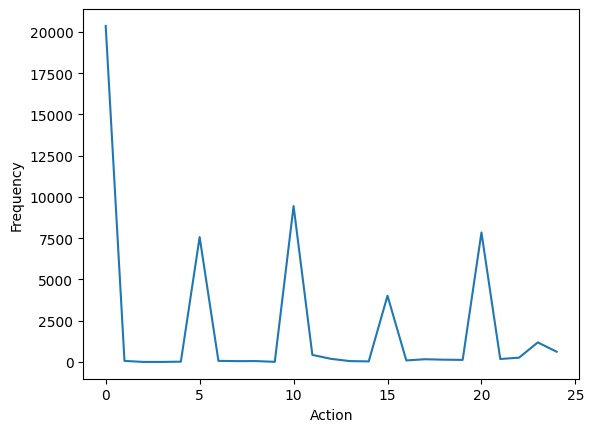

In [7]:
### Physician policy estimation ###

# train new policy
#physician_policy = compute_physician_policy(train_df, verbose=True)
#torch.save(physician_policy.state_dict(), 'models/physician_policy.pth')

# load saved policy
physician_policy = BehaviorPolicy(state_dim=20, action_dim=25, hidden_dim=256)
physician_policy.load_state_dict(torch.load('models/physician_policy.pth'))

evaluate_physician_policy(physician_policy, test_df)

In [11]:
### FQE ###

# evaluate physician policy
physician_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, physician_policy)
print(f'{physician_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 858.11it/s]


physician_fqe_val=6.4860758781433105


In [8]:
# evaluate D3QN

d3qn_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, d3qn_agent)
print(f'{d3qn_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 910.56it/s]


d3qn_fqe_val=3.115577220916748


In [9]:
# evaluate CQL
cql_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, cql_agent)
print(f'{cql_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 919.21it/s]


cql_fqe_val=3.454349994659424


In [12]:
# evaluate IQL
iql_fqe_val = off_policy_eval_fqe(train_df, sepsis_df, iql_agent)
print(f'{iql_fqe_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 859.42it/s]


iql_fqe_val=5.254138946533203


In [8]:
### WIS ###

# evaluate D3QN
d3qn_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, d3qn_agent)
print(f'{d3qn_wis_val=}')

d3qn_wis_val=0.0


In [8]:
# evaluate CQL

cql_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, cql_agent)
print(f'{cql_wis_val=}')

cql_wis_val=-12.392529358924893


In [9]:
# evaluate IQL

iql_wis_val = off_policy_eval_wis(sepsis_df, physician_policy, iql_agent)
print(f'{iql_wis_val=}')

iql_wis_val=0.0


In [15]:
### DR ###

# evaluate D3QN
d3qn_dr_val = off_policy_eval_dr(sepsis_df, train_df, physician_policy, d3qn_agent)
print(f'{d3qn_dr_val=}')

100%|██████████████████████████████████████| 3308/3308 [00:03<00:00, 909.92it/s]


d3qn_dr_val=nan


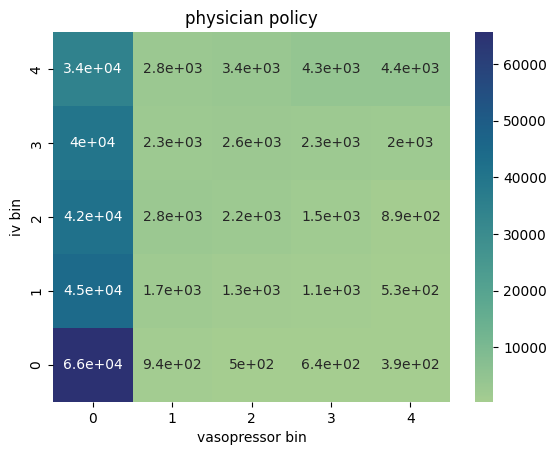

In [40]:
### Actual physician policy recorded in the data ###

df = pd.read_csv('data/sepsis_df.csv')

def get_action_log(df):
    action_log = np.zeros((5,5))
    for iv, vaso in zip(df['iv_bin'], df['vaso_bin']):
        action_log[(iv, vaso)] += 1
    return action_log

all_action_log = get_action_log(df)

fig, ax = plt.subplots()
policy_heatmap(all_action_log, 'physician', ax)

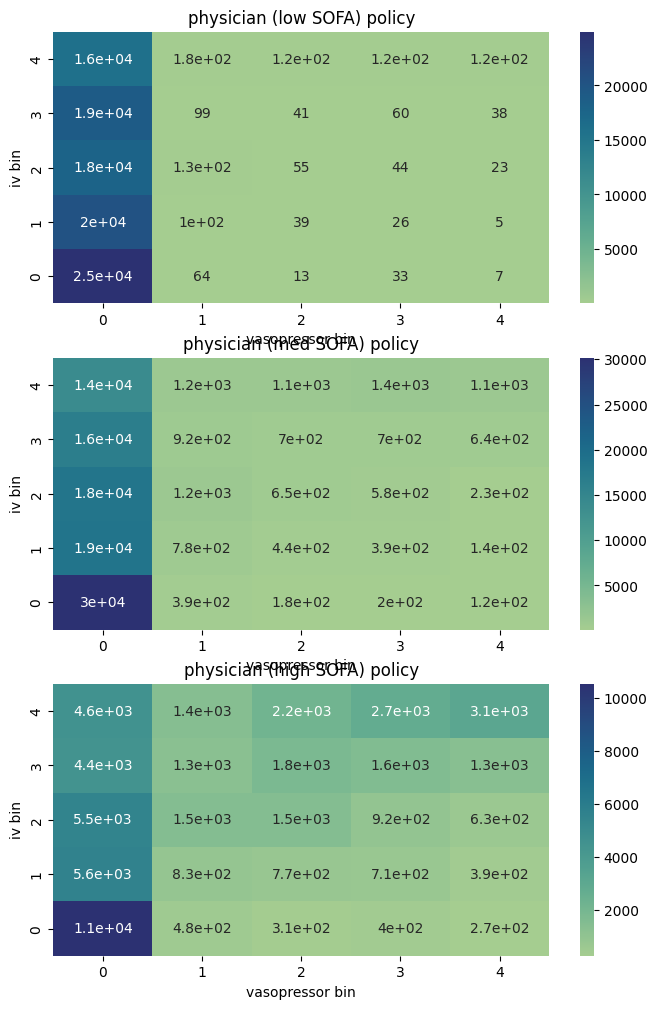

In [47]:
low_sofa_action_log = get_action_log(df[df['SOFA'] <= 4])
med_sofa_action_log = get_action_log(df[(df['SOFA'] > 4) & (df['SOFA'] <= 8)])
high_sofa_action_log = get_action_log(df[df['SOFA'] > 8])

fig, axs = plt.subplots(3, 1, figsize=(8,12))
policy_heatmap(low_sofa_action_log, 'physician (low SOFA)', axs[0])
policy_heatmap(med_sofa_action_log, 'physician (med SOFA)', axs[1])
policy_heatmap(high_sofa_action_log, 'physician (high SOFA)', axs[2])

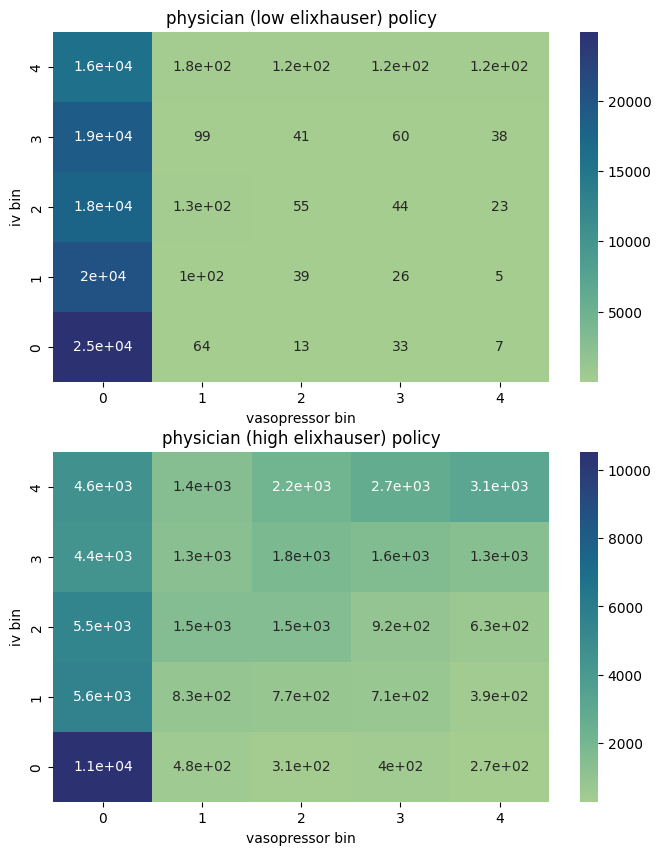

In [44]:
low_elixhauser_action_log = get_action_log(df[df['elixhauser'] < df['elixhauser'].mean()])
high_elixhauser_action_log = get_action_log(df[df['SOFA'] >= df['elixhauser'].mean()])

fig, axs = plt.subplots(2, 1, figsize=(8,10))
policy_heatmap(low_sofa_action_log, 'physician (low elixhauser)', axs[0])
policy_heatmap(high_sofa_action_log, 'physician (high elixhauser)', axs[1])

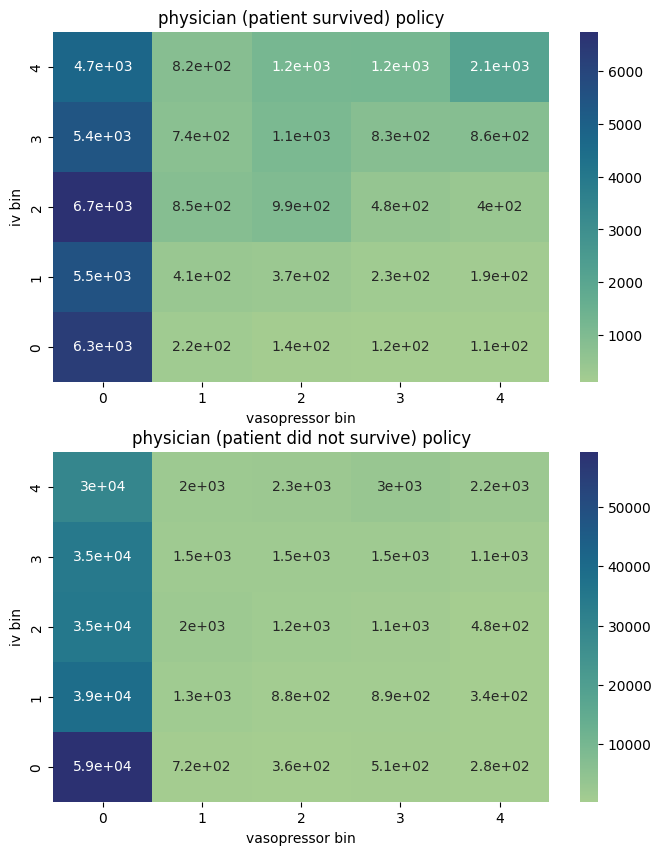

In [55]:
surv_action_log = get_action_log(df[df['died_in_hosp'] == 1])
died_action_log = get_action_log(df[df['died_in_hosp'] == 0])

fig, axs = plt.subplots(2, 1, figsize=(8,10))
policy_heatmap(surv_action_log, 'physician (patient survived)', axs[0])
policy_heatmap(died_action_log, 'physician (patient did not survive)', axs[1])